In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.stats import t
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 

In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


In [3]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

In [4]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [5]:
draft_df = pd.read_csv('career_df_2006.csv')

In [6]:
draft_df.columns

Index(['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)',
       '40 Yard', 'Bench Press', 'Vert Leap (in)', 'Broad Jump (in)',
       'Shuttle', '3Cone', 'Win-Loss Record', 'Round', 'Pick', 'Team', 'Age',
       'To', 'AP1', 'PB', 'St', 'CarAV', 'DrAV', 'Solo', 'Int', 'Sacks',
       'Drafted'],
      dtype='object')

In [7]:
draft_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),...,To,AP1,PB,St,CarAV,DrAV,Solo,Int,Sacks,Drafted
0,2006.0,Darrell Adams,Villanova,DE,76.63,277.0,5.08,22.0,27.0,109.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U
1,2006.0,Titus Adams,Nebraska,DT,75.38,306.0,5.12,15.0,30.5,103.0,...,2009.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,D
2,2006.0,Jahmile Addae,West Virginia,FS,70.25,214.0,4.74,NaN,38.5,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U
3,2006.0,Victor Adeyanju,Indiana,DE,76.25,274.0,4.88,22.0,32.0,112.0,...,2009.0,0.0,0.0,2.0,13.0,13.0,109.0,NaN,3.0,D
4,2006.0,Jason Allen,Tennessee,FS,72.88,209.0,4.41,17.0,39.5,131.0,...,2012.0,0.0,0.0,1.0,13.0,9.0,213.0,15.0,NaN,D


In [8]:
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             168 non-null    float64
 1   Name             168 non-null    object 
 2   College          168 non-null    object 
 3   POS              168 non-null    object 
 4   Height (in)      168 non-null    float64
 5   Weight (lbs)     168 non-null    float64
 6   40 Yard          132 non-null    float64
 7   Bench Press      115 non-null    float64
 8   Vert Leap (in)   128 non-null    float64
 9   Broad Jump (in)  129 non-null    float64
 10  Shuttle          108 non-null    float64
 11  3Cone            101 non-null    float64
 12  Win-Loss Record  155 non-null    object 
 13  Round            108 non-null    float64
 14  Pick             108 non-null    float64
 15  Team             108 non-null    object 
 16  Age              101 non-null    float64
 17  To              

In [9]:
drafted= draft_df[draft_df['Drafted'] == 'D']
undrafted = draft_df[draft_df['Drafted'] == 'U']


# Exploring Bench Press

In [10]:
draft_df.groupby(by='Drafted')['Bench Press'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,81.0,21.839506,7.265426,7.0,17.0,21.0,25.0,44.0
U,34.0,19.352941,7.803971,7.0,15.0,17.5,22.0,45.0


In [11]:
bench_mean = round(np.mean(draft_df['Bench Press']), 3)
bench_std= round(np.std(draft_df['Bench Press']), 3)
bench_mean, bench_std

(21.104, 7.449)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


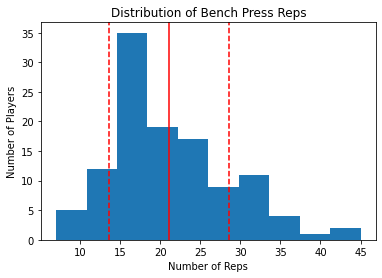

In [12]:
_ = plt.hist(draft_df['Bench Press'])
_ = plt.xlabel('Number of Reps')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Bench Press Reps')
_ = plt.axvline(bench_mean, color='r')
_ = plt.axvline(bench_mean + bench_std, color='r', linestyle='--')
_ = plt.axvline(bench_mean - bench_std, color='r', linestyle='--')

In [13]:
bench_draft = drafted['Bench Press']
bench_udraft = undrafted['Bench Press']


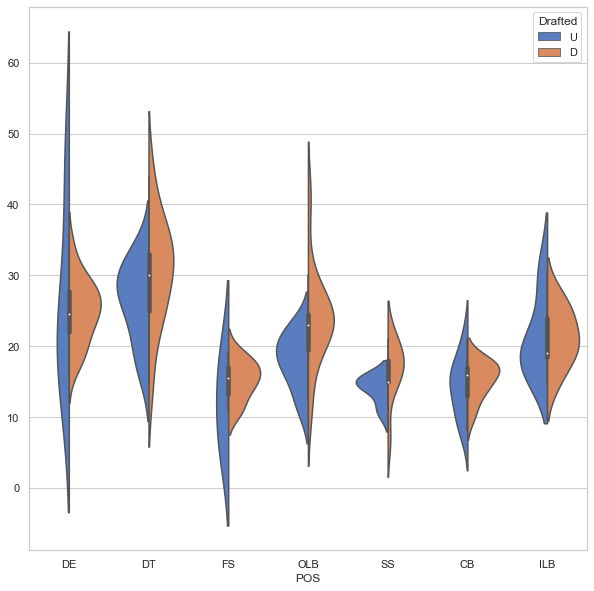

In [14]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="Bench Press", hue="Drafted", split=True)
_ = ax.set(ylabel="")

# Exploring 40 Yard Dash

In [15]:
draft_df.groupby(by='Drafted')['40 Yard'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,94.0,4.711277,0.246556,4.34,4.520,4.65,4.855,5.46
U,38.0,4.847368,0.208387,4.47,4.695,4.81,4.975,5.29


In [16]:
yard40_mean = round(np.mean(draft_df['40 Yard']), 3)
yard40_std = round(np.std(draft_df['40 Yard']), 3)
yard40_mean, yard40_std

(4.75, 0.242)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


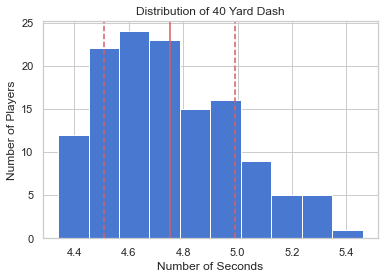

In [17]:
_ = plt.hist(draft_df['40 Yard'])
_ = plt.xlabel('Number of Seconds')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of 40 Yard Dash')
_ = plt.axvline(yard40_mean, color='r')
_ = plt.axvline(yard40_mean + yard40_std, color='r', linestyle='--')
_ = plt.axvline(yard40_mean - yard40_std, color='r', linestyle='--')

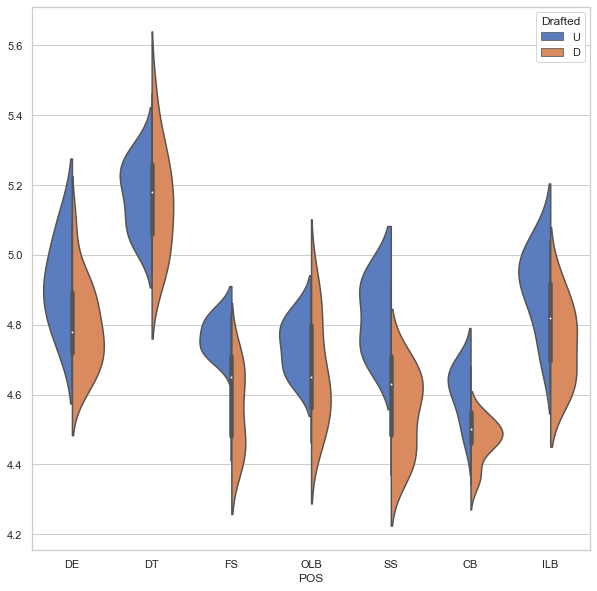

In [18]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="40 Yard", hue="Drafted", split=True)
_ = ax.set(ylabel="")

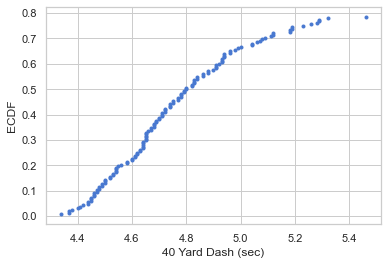

In [19]:
x_yard, y_yard = ecdf(draft_df['40 Yard'])

_ = plt.plot(x_yard, y_yard, marker='.', linestyle='none')

_ = plt.xlabel('40 Yard Dash (sec)')
_ = plt.ylabel('ECDF')

In [20]:
yard_draft = drafted['40 Yard']
yard_udraft = undrafted['40 Yard']
np.mean(yard_draft), np.mean(yard_udraft)

(4.711276595744682, 4.847368421052632)

In [21]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 6]):
        draft_df.iloc[i, 6] = np.mean(drafted['40 Yard'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 6]):
        draft_df.iloc[i, 6] = np.mean(undrafted['40 Yard'])


In [22]:
#draft_df['Permutation40'] = np.random.permutation(draft_df['40 Yard'])

#draft_df.groupby(by='Drafted')['Permutation40'].describe()

In [23]:
diff40 = []

for i in range(10000):
    perm = np.random.permutation(draft_df['40 Yard'])
    mean_diff = np.mean(perm[draft_df['Drafted'] == 'D']) - np.mean(perm[draft_df['Drafted'] == 'U'])
    diff40.append(mean_diff)

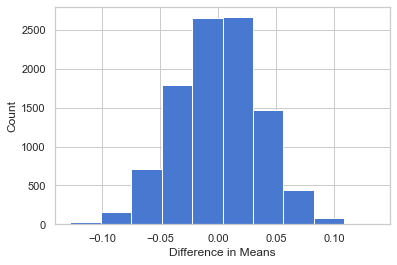

In [24]:
_ = plt.hist(diff40)
_ = plt.xlabel('Difference in Means')
_ = plt.ylabel('Count')

In [25]:
yard40_obs = np.mean(yard_draft) - np.mean(yard_udraft)
yard40_obs = abs(yard40_obs)
print(yard40_obs)

0.1360918253079504


In [26]:
pos_extreme = []
neg_extreme = []

for j in range(len(diff40)):
    if(diff40[j] >= yard40_obs):
        pos_extreme.append(diff40[j])
    elif(diff40[j] <= -yard40_obs):
        neg_extreme.append(diff40[j])
print(len(pos_extreme))
print(len(neg_extreme))

0
0


Lower than 5% reject null hypothesis

# Exploring Vertical Leap

In [27]:
draft_df.groupby(by='Drafted')['Vert Leap (in)'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,90.0,36.322222,3.727601,25.0,33.50,37.00,39.375,42.0
U,38.0,34.407895,3.741396,27.0,31.25,34.25,37.000,41.5


In [28]:
vert_leap_mean = round(np.mean(draft_df['Vert Leap (in)']), 3)
vert_leap_std = round(np.std(draft_df['Vert Leap (in)']), 3)
vert_leap_mean, vert_leap_std

(35.754, 3.804)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


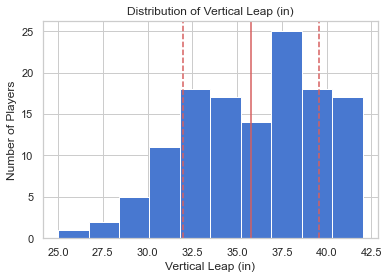

In [29]:
_ = plt.hist(draft_df['Vert Leap (in)'])
_ = plt.xlabel('Vertical Leap (in)')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Vertical Leap (in)')

_ = plt.axvline(vert_leap_mean, color='r')
_ = plt.axvline(vert_leap_mean + vert_leap_std, color='r', linestyle='--')
_ = plt.axvline(vert_leap_mean - vert_leap_std, color='r', linestyle='--')

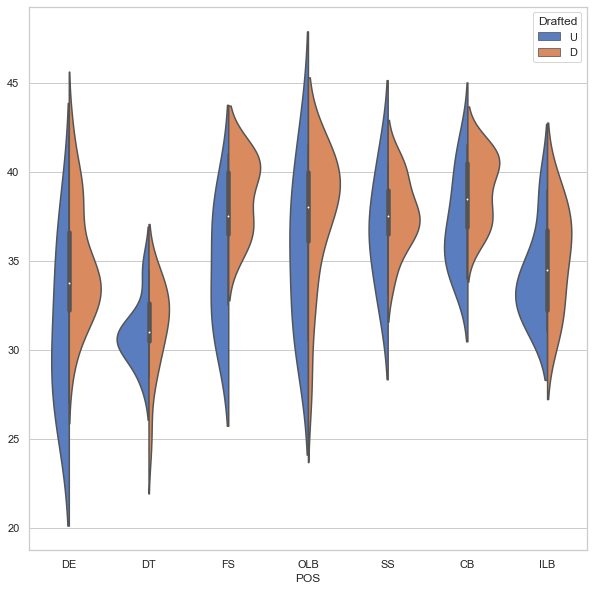

In [30]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y='Vert Leap (in)', hue="Drafted", split=True)
_ = ax.set(ylabel="")

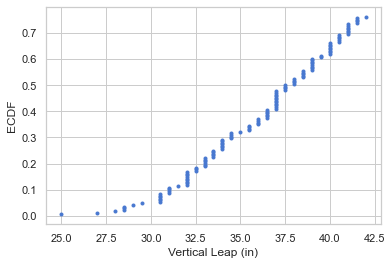

In [31]:
x_vert, y_vert = ecdf(draft_df['Vert Leap (in)'])

_ = plt.plot(x_vert, y_vert, marker='.', linestyle='none')

_ = plt.xlabel('Vertical Leap (in)')
_ = plt.ylabel('ECDF')

In [32]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 8]):
        draft_df.iloc[i, 8] = np.mean(drafted['Vert Leap (in)'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 8]):
        draft_df.iloc[i, 8] = np.mean(undrafted['Vert Leap (in)'])

In [33]:
#draft_df['PermutationVert'] = np.random.permutation(draft_df['Vert Leap (in)'])

#draft_df.groupby(by='Drafted')['PermutationVert'].describe()

In [34]:
diffVert = []

for i in range(10000):
    perm_vert = np.random.permutation(draft_df['Vert Leap (in)'])
    mean_vert_diff = np.mean(perm_vert[draft_df['Drafted'] == 'D']) - np.mean(perm_vert[draft_df['Drafted'] == 'U'])
    diffVert.append(mean_vert_diff)

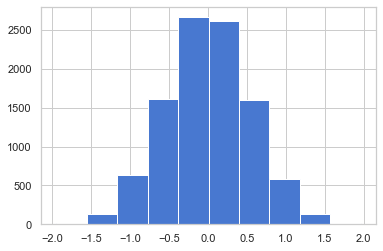

In [35]:
_ = plt.hist(diffVert)

In [36]:
obs_vert_diff = np.mean(draft_df[draft_df['Drafted'] == 'D'])['Vert Leap (in)'] - np.mean(draft_df[draft_df['Drafted'] == 'U'])['Vert Leap (in)']

obs_vert_diff = abs(obs_vert_diff)

print(obs_vert_diff)

1.914327485380113


In [37]:
pos_extreme_vert = []
neg_extreme_vert = []

for j in range(len(diffVert)):
    if(diffVert[j] >= obs_vert_diff):
        pos_extreme_vert.append(diffVert[j])
    elif(diffVert[j] <= -obs_vert_diff):
        neg_extreme_vert.append(diffVert[j])
print(len(pos_extreme_vert))
print(len(neg_extreme_vert))

1
2


Lower than 5% reject null hypothesis

# Exploring Broad Jump

In [38]:
draft_df.groupby(by='Drafted')['Broad Jump (in)'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,91.0,118.714286,8.341710,96.0,113.0,120.0,125.00,133.0
U,38.0,114.263158,6.202372,100.0,109.0,114.5,117.75,127.0


In [39]:
broad_jump_mean = round(np.mean(draft_df['Broad Jump (in)']), 3)
broad_jump_std = round(np.std(draft_df['Broad Jump (in)']), 3)
broad_jump_mean, broad_jump_std

(117.403, 7.981)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


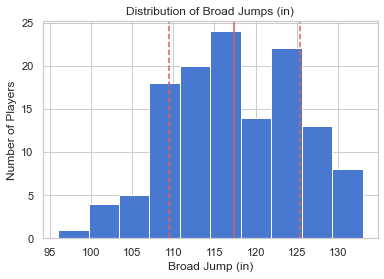

In [40]:
_ = plt.hist(draft_df['Broad Jump (in)'])
_ = plt.xlabel('Broad Jump (in)')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Broad Jumps (in)')
_ = plt.axvline(broad_jump_mean, color='r')
_ = plt.axvline(broad_jump_mean + broad_jump_std, color='r', linestyle='--')
_ = plt.axvline(broad_jump_mean - broad_jump_std, color='r', linestyle='--')

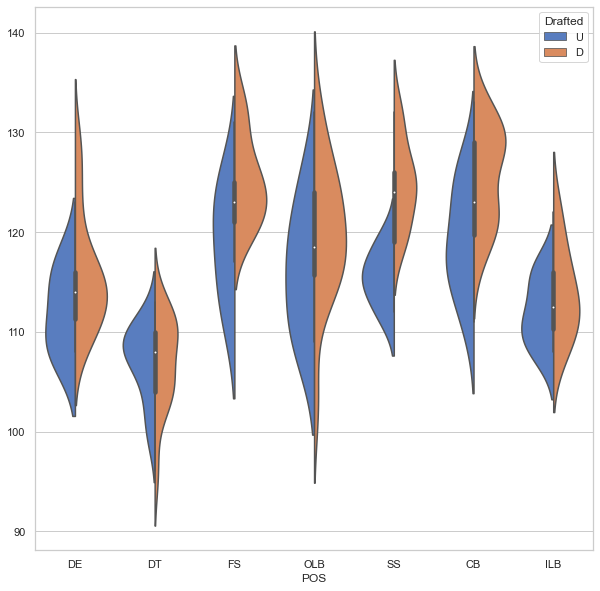

In [41]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="Broad Jump (in)", hue="Drafted", split=True)
_ = ax.set(ylabel="")

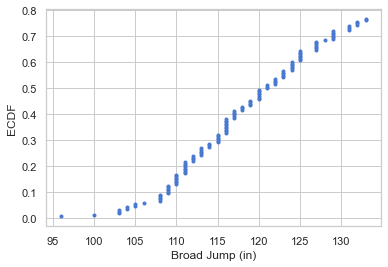

In [42]:
x_broad, y_broad = ecdf(draft_df['Broad Jump (in)'])

_ = plt.plot(x_broad, y_broad, marker='.', linestyle='none')

_ = plt.xlabel('Broad Jump (in)')
_ = plt.ylabel('ECDF')

In [43]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 9]):
        draft_df.iloc[i, 9] = np.mean(drafted['Broad Jump (in)'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 9]):
        draft_df.iloc[i, 9] = np.mean(undrafted['Broad Jump (in)'])

In [44]:
#draft_df['PermutationBroad'] = np.random.permutation(draft_df['Broad Jump (in)'])

#draft_df.groupby(by='Drafted')['PermutationBroad'].describe()

In [45]:
diffBroad = []

for i in range(10000):
    perm_broad = np.random.permutation(draft_df['Broad Jump (in)'])
    mean_broad_diff = np.mean(perm_broad[draft_df['Drafted'] == 'D']) - np.mean(perm_broad[draft_df['Drafted'] == 'U'])
    diffBroad.append(mean_broad_diff)

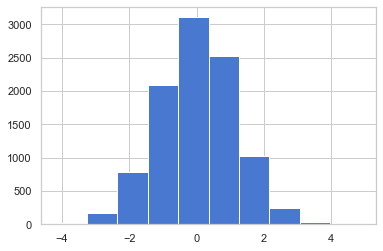

In [46]:
_ = plt.hist(diffBroad)

In [47]:
obs_broad_diff = np.mean(draft_df[draft_df['Drafted'] == 'D'])['Broad Jump (in)'] - np.mean(draft_df[draft_df['Drafted'] == 'U'])['Broad Jump (in)']

obs_broad_dff = abs(obs_broad_diff)

print(obs_broad_diff)

4.451127819548958


In [48]:
pos_extreme_broad = []
neg_extreme_broad = []

for j in range(len(diffBroad)):
    if(diffBroad[j] >= obs_broad_diff):
        pos_extreme_broad.append(diffBroad[j])
    elif(diffBroad[j] <= -obs_broad_diff):
        neg_extreme_broad.append(diffBroad[j])
print(len(pos_extreme_broad))
print(len(neg_extreme_broad))

1
0


Lower than 5% reject null hypothesis

# Exploring Shuttle Run

In [49]:
draft_df.groupby(by='Drafted')['Shuttle'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,78.0,4.269615,0.185090,3.81,4.1325,4.23,4.3975,4.80
U,30.0,4.353333,0.233819,4.07,4.1725,4.30,4.4425,4.92


In [50]:
shuttle_mean = round(np.mean(draft_df['Shuttle']), 3)
shuttle_std = round(np.std(draft_df['Shuttle']), 3)
shuttle_mean, shuttle_std

(4.293, 0.201)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


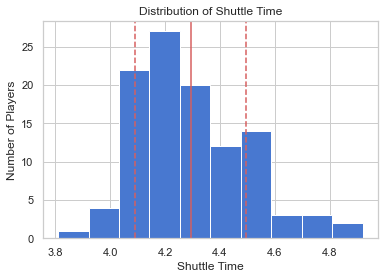

In [51]:
_ = plt.hist(draft_df['Shuttle'])
_ = plt.xlabel('Shuttle Time')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Shuttle Time')
_ = plt.axvline(shuttle_mean, color='r')
_ = plt.axvline(shuttle_mean + shuttle_std, color='r', linestyle='--')
_ = plt.axvline(shuttle_mean - shuttle_std, color='r', linestyle='--')

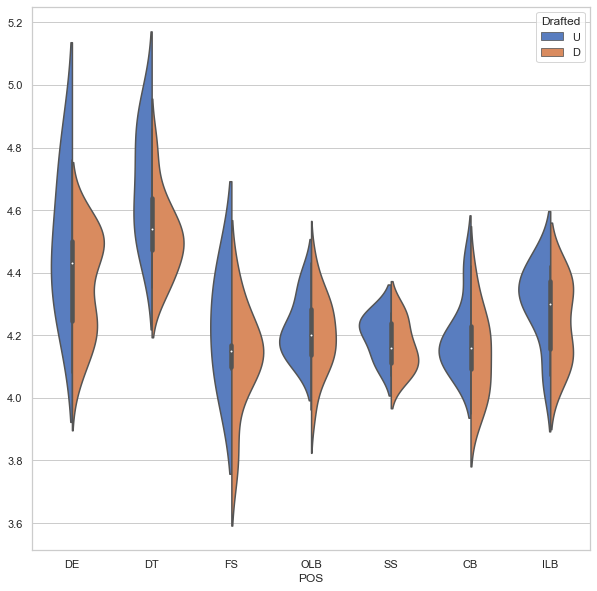

In [52]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="Shuttle", hue="Drafted", split=True)
_ = ax.set(ylabel="")

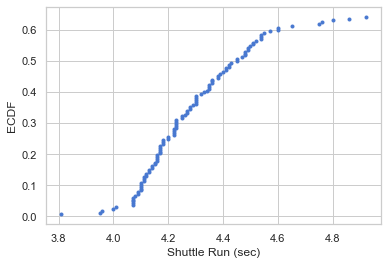

In [53]:
x_shuttle, y_shuttle = ecdf(draft_df['Shuttle'])

_ = plt.plot(x_shuttle, y_shuttle, marker='.', linestyle='none')

_ = plt.xlabel('Shuttle Run (sec)')
_ = plt.ylabel('ECDF')

In [54]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 10]):
        draft_df.iloc[i, 10] = np.mean(drafted['Shuttle'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 10]):
        draft_df.iloc[i, 10] = np.mean(undrafted['Shuttle'])

In [55]:
#draft_df['PermutationShuttle'] = np.random.permutation(draft_df['Shuttle'])

#draft_df.groupby(by='Drafted')['PermutationShuttle'].describe()

In [56]:
diffShuttle = []

for i in range(10000):
    perm_shuttle = np.random.permutation(draft_df['Shuttle'])
    mean_shuttle_diff = np.mean(perm_shuttle[draft_df['Drafted'] == 'D']) - np.mean(perm_shuttle[draft_df['Drafted'] == 'U'])
    diffShuttle.append(mean_shuttle_diff)

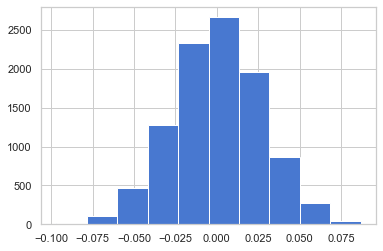

In [57]:
_ = plt.hist(diffShuttle)

In [58]:
obs_shuttle_diff = np.mean(draft_df[draft_df['Drafted'] == 'D'])['Shuttle'] - np.mean(draft_df[draft_df['Drafted'] == 'U'])["Shuttle"]

obs_shuttle_diff = abs(obs_shuttle_diff)

print(obs_shuttle_diff)

0.08371794871794336


In [59]:
pos_extreme_shuttle = []
neg_extreme_shuttle = []

for j in range(len(diffShuttle)):
    if(diffShuttle[j] >= obs_shuttle_diff):
        pos_extreme_shuttle.append(diffShuttle[j])
    elif(diffShuttle[j] <= -obs_shuttle_diff):
        neg_extreme_shuttle.append(diffShuttle[j])
print(len(pos_extreme_shuttle))
print(len(neg_extreme_shuttle))

3
5


Lower than 5% reject null hypothesis

# Exploring Three Cone Drill

In [60]:
draft_df.groupby(by='Drafted')['3Cone'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,75.0,7.201733,0.375094,6.63,6.9350,7.160,7.4050,8.28
U,26.0,7.308077,0.359522,6.81,7.0225,7.225,7.5875,8.12


In [61]:
cone3_mean = round(np.mean(draft_df['3Cone']), 3)
cone3_std = round(np.std(draft_df['3Cone']), 3)
cone3_mean, cone3_std

(7.229, 0.37)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


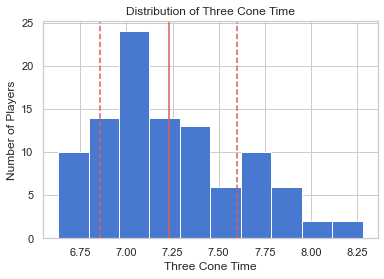

In [62]:
_ = plt.hist(draft_df['3Cone'])
_ = plt.xlabel('Three Cone Time')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Three Cone Time')
_ = plt.axvline(cone3_mean, color='r')
_ = plt.axvline(cone3_mean + cone3_std, color='r', linestyle='--')
_ = plt.axvline(cone3_mean - cone3_std, color='r', linestyle='--')

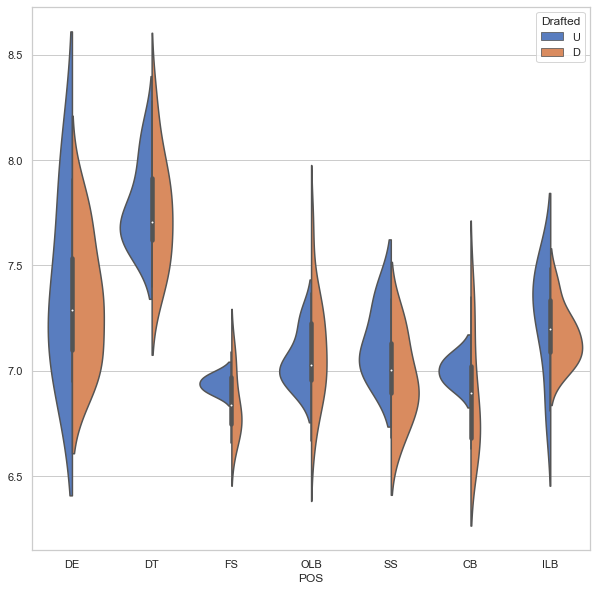

In [63]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="3Cone", hue="Drafted", split=True)
_ = ax.set(ylabel="")

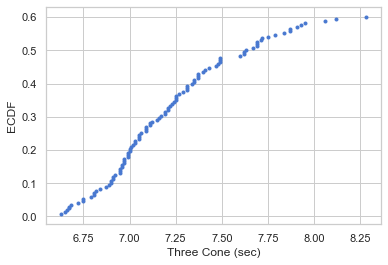

In [64]:
x_cone, y_cone = ecdf(draft_df['3Cone'])

_ = plt.plot(x_cone, y_cone, marker='.', linestyle='none')

_ = plt.xlabel('Three Cone (sec)')
_ = plt.ylabel('ECDF')

In [65]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 11]):
        draft_df.iloc[i, 11] = np.mean(drafted['3Cone'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 11]):
        draft_df.iloc[i, 11] = np.mean(undrafted['3Cone'])

In [66]:
#draft_df['PermutationCone'] = np.random.permutation(draft_df['3Cone'])

#draft_df.groupby(by='Drafted')['PermutationCone'].describe()

In [67]:
diffCone = []

for i in range(10000):
    perm_cone = np.random.permutation(draft_df['3Cone'])
    mean_cone_diff = np.mean(perm_cone[draft_df['Drafted'] == 'D']) - np.mean(perm_cone[draft_df['Drafted'] == 'U'])
    diffCone.append(mean_cone_diff)

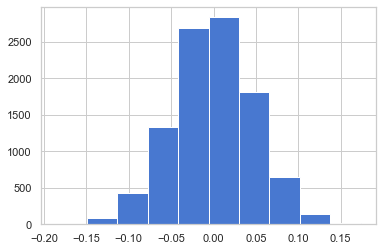

In [68]:
_ = plt.hist(diffCone)

In [69]:
obs_cone_diff = np.mean(draft_df[draft_df['Drafted'] == 'D'])['3Cone'] - np.mean(draft_df[draft_df['Drafted'] == 'U'])['3Cone']

obs_cone_diff = abs(obs_cone_diff)

print(obs_cone_diff)

0.1063435897435907


In [70]:
pos_extreme_cone = []
neg_extreme_cone = []

for j in range(len(diffCone)):
    if(diffCone[j] >= obs_cone_diff):
        pos_extreme_cone.append(diffCone[j])
    elif(diffCone[j] <= -obs_cone_diff):
        neg_extreme_cone.append(diffCone[j])
print(len(pos_extreme_cone))
print(len(neg_extreme_cone))

116
146


Lower than 5% reject the null hypothesis

In [71]:
np.where(np.isnan(drafted['To']), drafted['Name'], 0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 'Josh Lay', 0, 0, 0, 0, 0, 0, 0,
       'Dee McCann', 0, 0, 0, 'Gerrick McPhearson', 0, 'DeMario Minter',
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'Justin Phinisee', 0, 0, 0, 0, 0, 0,
       0, 'Kevin Simon', 0, 0, 0, 0, 0, 0, 0, 0, 'Vickiel Vaughn', 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [72]:
drafted[drafted['Name'] == 'Dee McCann']

,Year,Name,College,POS,Height (in),Weight (lbs),40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),...,To,AP1,PB,St,CarAV,DrAV,Solo,Int,Sacks,Drafted
100,2006.0,Dee McCann,West Virginia,CB,71.25,197.0,4.54,NaN,40.5,122.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,D


In [111]:
drafted['Solos_Per_Year'] = 0
drafted['Ints_Per_Year'] = 0
drafted['Sacks_Per_Year'] = 0
drafted['Solos_Per_Game'] = 0

drafted['To'].replace(np.nan, 2006.0, inplace=True)
drafted['Broad Jump (in)'].replace(np.nan, np.mean(drafted['Broad Jump (in)']), inplace=True)
drafted['Solo'].replace(np.nan, 0, inplace=True)
drafted['Solos_Per_Year'].replace(np.nan, np.mean(drafted['Solos_Per_Year']), inplace=True)
drafted['Bench Press'].replace(np.nan, np.mean(drafted['Bench Press']), inplace=True)
drafted['40 Yard'].replace(np.nan, np.mean(drafted['40 Yard']), inplace=True)
drafted['Vert Leap (in)'].replace(np.nan, np.mean(drafted['Vert Leap (in)']), inplace=True)
drafted['Shuttle'].replace(np.nan, np.mean(drafted['Shuttle']), inplace=True)
drafted['3Cone'].replace(np.nan, np.mean(drafted['3Cone']), inplace=True)
drafted['Int'].replace(np.nan, 0, inplace=True)
drafted['Ints_Per_Year'].replace(np.nan, 0, inplace=True)
drafted['Sacks'].replace(np.nan, 0, inplace=True)
drafted['Sacks_Per_Year'].replace(np.nan, 0, inplace=True)


<ipython-input-111-311bf7215556>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drafted['Solos_Per_Year'] = 0
<ipython-input-111-311bf7215556>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drafted['Ints_Per_Year'] = 0
<ipython-input-111-311bf7215556>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [112]:
#Solos Per Year Filler
for i in range(len(drafted)):
    if((drafted.iloc[i, 17] - drafted.iloc[i, 0]) == 0):
        drafted.iloc[i, 27] = round(drafted.iloc[i, 23] / 1)
    else:
        drafted.iloc[i, 27] = round(drafted.iloc[i, 23] / (drafted.iloc[i, 17] - drafted.iloc[i, 0]), 2)


C:\Users\vtkurt13\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [113]:
#Solos Per Game Filler

for i in range(len(drafted)):
    if((drafted.iloc[i, 17] - drafted.iloc[i, 0]) == 0):
        drafted.iloc[i, 30] = round(drafted.iloc[i, 23] / 1)
    else:
        per_year = round(drafted.iloc[i, 23] / (drafted.iloc[i, 17] - drafted.iloc[i, 0]), 2)
        drafted.iloc[i, 30] = per_year / 16

In [114]:
#Ints Per Game Filler

for i in range(len(drafted)):
    if((drafted.iloc[i, 17] - drafted.iloc[i, 0]) == 0):
        drafted.iloc[i, 28] = round(drafted.iloc[i, 24] / 1)
    else:
        drafted.iloc[i, 28] = round(drafted.iloc[i, 24] / (drafted.iloc[i, 17] - drafted.iloc[i, 0]), 2)


In [115]:
#Sacks Per Year Filler

for i in range(len(drafted)):
    if((drafted.iloc[i, 17] - drafted.iloc[i, 0]) == 0):
        drafted.iloc[i, 29] = round(drafted.iloc[i, 25] / 1)
    else:
        drafted.iloc[i, 29] = round(drafted.iloc[i, 25] / (drafted.iloc[i, 17] - drafted.iloc[i, 0]), 2)
drafted

,Year,Name,College,POS,Height (in),Weight (lbs),40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),...,CarAV,DrAV,Solo,Int,Sacks,Drafted,Solos_Per_Year,Ints_Per_Year,Sacks_Per_Year,Solos_Per_Game
1,2006.0,Titus Adams,Nebraska,DT,75.38,306.0,5.120000,15.000000,30.500000,103.000000,...,0.0,NaN,1.0,0.0,0.0,D,0.33,0.00,0.00,0.020625
3,2006.0,Victor Adeyanju,Indiana,DE,76.25,274.0,4.880000,22.000000,32.000000,112.000000,...,13.0,13.0,109.0,0.0,3.0,D,36.33,0.00,1.00,2.270625
4,2006.0,Jason Allen,Tennessee,FS,72.88,209.0,4.410000,17.000000,39.500000,131.000000,...,13.0,9.0,213.0,15.0,0.0,D,35.50,2.50,0.00,2.218750
5,2006.0,Jon Alston,Stanford,OLB,72.75,223.0,4.530000,30.000000,40.000000,132.000000,...,6.0,0.0,51.0,0.0,0.0,D,17.00,0.00,0.00,1.062500
6,2006.0,James Anderson,Virginia Tech,OLB,74.75,229.0,4.620000,21.839506,41.000000,121.000000,...,31.0,25.0,421.0,3.0,12.0,D,46.78,0.33,1.33,2.923750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2006.0,Mario Williams,North Carolina State,DE,74.40,269.0,4.750000,25.000000,34.000000,111.000000,...,76.0,34.0,317.0,0.0,97.5,D,31.70,0.00,9.75,1.981250
163,2006.0,Kamerion Wimbley,Florida State,DE,75.88,248.0,4.640000,24.000000,38.500000,129.000000,...,44.0,23.0,322.0,2.0,53.5,D,40.25,0.25,6.69,2.515625
164,2006.0,Rodrique Wright,Texas,DT,77.13,300.0,5.110000,31.000000,32.000000,110.000000,...,4.0,4.0,28.0,0.0,1.5,D,14.00,0.00,0.75,0.875000
165,2006.0,Claude Wroten,Louisiana State,DT,74.00,302.0,4.711277,21.839506,36.322222,118.714286,...,2.0,2.0,21.0,0.0,1.5,D,21.00,0.00,1.50,1.312500


In [116]:
draft_df.corr()

,Year,Height (in),Weight (lbs),40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone,Round,...,Age,To,AP1,PB,St,CarAV,DrAV,Solo,Int,Sacks
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Height (in),NaN,1.000000,0.642057,0.387461,0.344016,-0.300082,-0.299736,0.322828,0.316469,-0.012376,...,0.133491,-0.012365,-0.001933,-0.073152,0.045188,-0.000314,0.088967,-0.247874,-0.321730,0.220018
Weight (lbs),NaN,0.642057,1.000000,0.707157,0.707069,-0.525628,-0.601679,0.542388,0.569454,0.068643,...,0.058691,-0.024527,0.130115,0.037257,0.070033,0.043118,0.167902,-0.265556,-0.346832,0.163380
40 Yard,NaN,0.387461,0.707157,1.000000,0.476696,-0.729639,-0.812000,0.630407,0.664550,0.195083,...,0.064490,-0.004473,0.116859,-0.017054,0.019414,0.029552,0.156143,-0.232514,-0.378827,0.126430
Bench Press,NaN,0.344016,0.707069,0.476696,1.000000,-0.284253,-0.390276,0.414970,0.424381,-0.043204,...,-0.044985,0.086691,0.228809,0.105332,0.151306,0.170382,0.206227,-0.128864,-0.300647,0.240934
Vert Leap (in),NaN,-0.300082,-0.525628,-0.729639,-0.284253,1.000000,0.796936,-0.571997,-0.604430,-0.145970,...,-0.062961,-0.026344,-0.090094,-0.043430,-0.049624,-0.038362,-0.123163,0.178686,0.104938,-0.107921
Broad Jump (in),NaN,-0.299736,-0.601679,-0.812000,-0.390276,0.796936,1.000000,-0.588959,-0.645854,-0.218306,...,-0.109931,0.045821,-0.046137,0.054706,0.028563,0.018622,-0.112959,0.273976,0.368982,-0.085435
Shuttle,NaN,0.322828,0.542388,0.630407,0.414970,-0.571997,-0.588959,1.000000,0.766283,0.184711,...,0.014855,-0.043095,0.195499,0.147675,0.002699,0.031308,0.057071,-0.208892,-0.116525,0.204624
3Cone,NaN,0.316469,0.569454,0.664550,0.424381,-0.604430,-0.645854,0.766283,1.000000,0.185078,...,0.107778,-0.123277,0.170327,0.109328,-0.037389,-0.021720,0.074372,-0.246701,-0.165982,0.062263
Round,NaN,-0.012376,0.068643,0.195083,-0.043204,-0.145970,-0.218306,0.184711,0.185078,1.000000,...,0.105255,-0.436996,-0.144477,-0.294532,-0.502627,-0.498377,-0.410534,-0.454208,-0.197394,-0.257054


In [117]:
#sns.pairplot(draft_df)

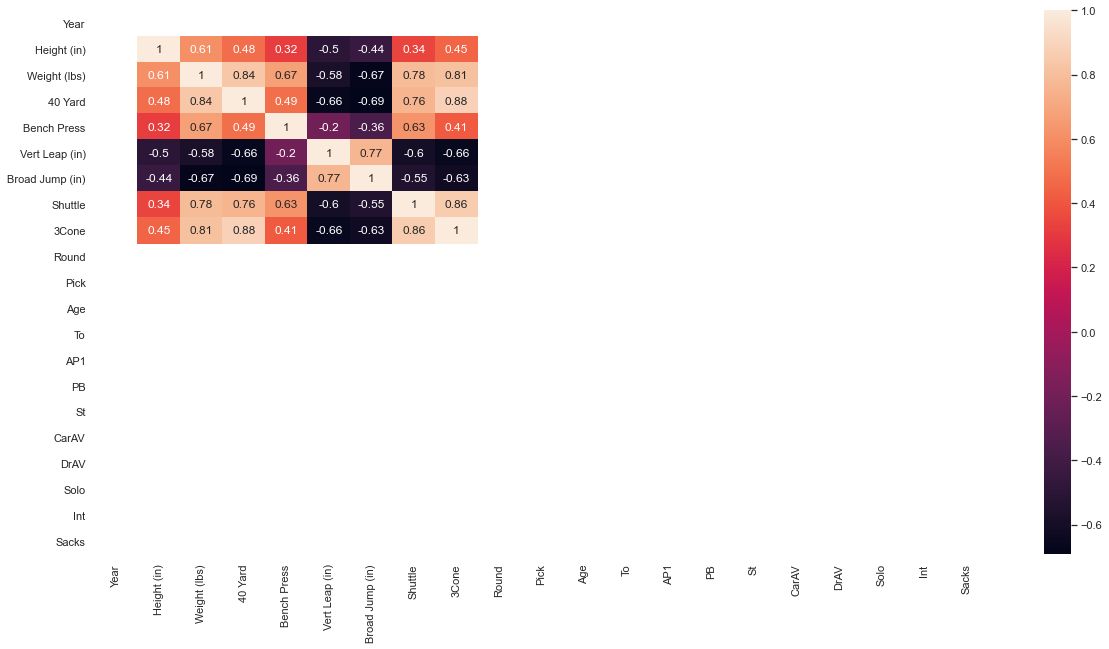

In [118]:
plt.figure(figsize=(20,10))
_ = sns.heatmap(undrafted.corr(), annot=True)

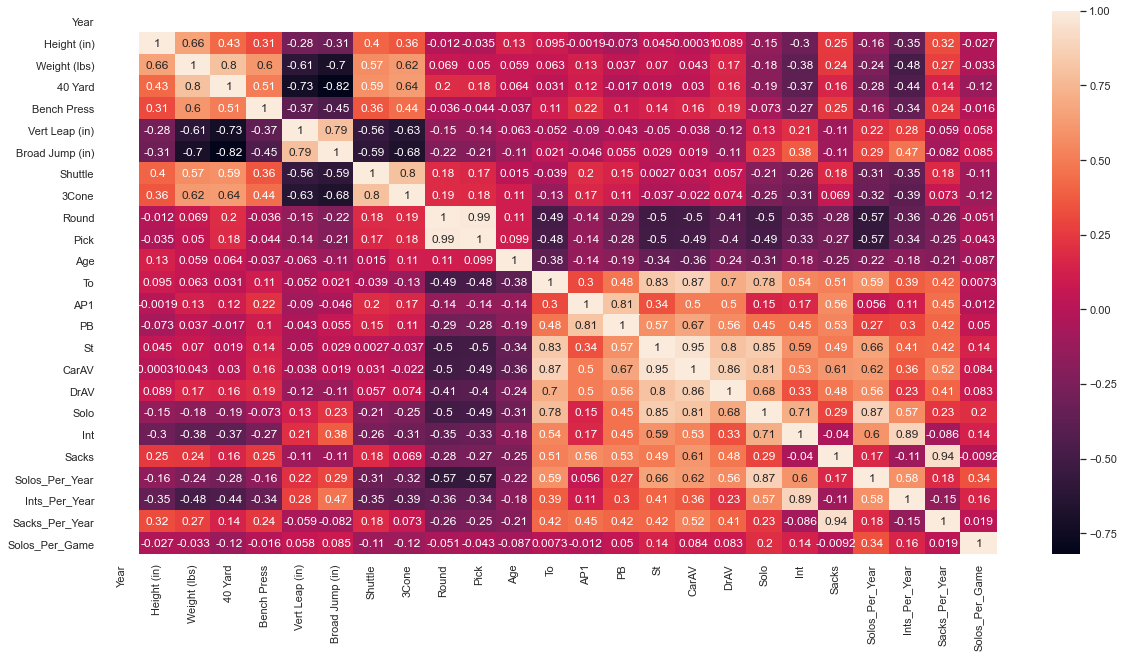

In [119]:
plt.figure(figsize=(20,10))
_ = sns.heatmap(drafted.corr(), annot=True)

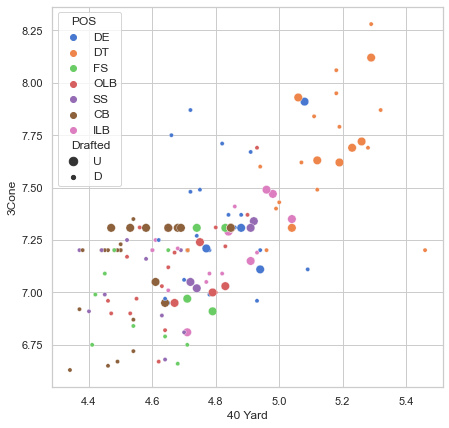

In [120]:
_ = plt.figure(figsize=(7, 7))
_ = sns.scatterplot(x='40 Yard', y='3Cone', data=draft_df, hue='POS', size='Drafted')

In [124]:
y = drafted[['Solos_Per_Game']]
#X = drafted.drop(columns=['Win-Loss Record', 'Solo', 'Round', 'Pick', 'Year', 'Drafted', 'DrAV', 'CarAV', 'AP1', 'Name', 'College', 'POS', 'To', 'Age', 'Team'])
X = drafted[['Height (in)', 'Weight (lbs)','40 Yard', 'Bench Press', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle', '3Cone']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [125]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(81, 8)
(27, 8)
(81, 1)
(27, 1)


In [126]:
rModel = linear_model.LinearRegression(normalize=True)

In [127]:
rModel.fit(X_train, y_train)

LinearRegression(normalize=True)

In [128]:
rModel.score(X_train, y_train)

0.03641023619219963

In [129]:
rModel.coef_

array([[-0.10379023,  0.02141351, -5.61538963,  0.0557551 , -0.07972489,
        -0.05562736, -0.24856991, -1.89055546]])

In [130]:
pred = rModel.predict(X_test)

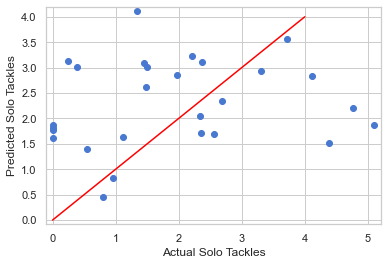

In [132]:
_ = plt.scatter(y_test, pred)
_ = plt.plot([x for x in range(0, 5)],[x for x in range(0, 5)], color='red')
_ = plt.margins(0.02)
_ = plt.xlabel('Actual Solo Tackles')
_ = plt.ylabel('Predicted Solo Tackles')